In [38]:
import numpy as np 
import numba
import random
import matplotlib.pyplot as plt 
import math

(8, 14)
(13, 6)
(5, 10)
(12, 14)
(6, 13)
(14, 9)
(7, 5)
(9, 14)
(12, 5)
(5, 8)
(5, 12)
(5, 9)
(14, 7)
(8, 14)
(12, 14)
(8, 14)
(11, 14)
(10, 5)
(14, 12)
(11, 14)
(5, 9)
(14, 7)
(12, 14)
(9, 14)
(12, 14)
(10, 5)
(11, 5)
(5, 9)
(6, 6)
(12, 5)
(14, 9)
(14, 9)
(13, 13)
(14, 12)
(9, 14)
(5, 7)
(5, 9)
(12, 5)
(10, 5)
(8, 5)
(12, 14)
(5, 8)
(14, 9)
(13, 13)
(14, 8)
(5, 9)
(12, 5)
(7, 5)
(5, 9)
(12, 5)
(7, 5)
(9, 5)
(5, 11)
(8, 5)
(6, 6)
(9, 14)
(6, 6)
(14, 9)
(5, 7)
(6, 6)
(8, 14)
(14, 11)
(13, 6)
(14, 11)
(14, 10)
(13, 6)
(14, 7)
(7, 5)
(11, 5)
(8, 14)
(11, 5)
(13, 6)
(8, 5)
(10, 5)
(11, 5)
(14, 10)
(6, 6)
(8, 14)
(5, 8)
(14, 11)
(13, 6)
(14, 8)
(9, 14)
(11, 5)
(12, 14)
(6, 6)
(11, 5)
(6, 6)
(7, 5)
(12, 14)
(7, 14)
(9, 5)
(14, 10)
(10, 5)
(5, 10)
(13, 13)
(5, 9)
(8, 5)
(12, 5)
(8, 5)
(6, 13)
(14, 7)
(7, 14)
(8, 5)
(9, 5)
(13, 6)
(14, 9)
(12, 5)
(14, 12)
(5, 8)
(8, 14)
(10, 14)
(14, 11)
(14, 7)
(14, 9)
(5, 10)
(14, 7)
(8, 14)
(12, 5)
(10, 5)
(7, 5)
(14, 11)
(8, 14)
(10, 5)
(12, 14)
(8, 5)
(5,

(13, 6)
(11, 5)
(5, 12)
(14, 12)
(12, 14)
(13, 13)
(14, 12)
(13, 6)
(5, 11)
(5, 10)
(14, 7)
(14, 10)
(6, 6)
(9, 14)
(13, 6)
(11, 5)
(9, 14)
(12, 14)
(5, 12)
(13, 6)
(11, 14)
(7, 14)
(13, 13)
(14, 7)
(10, 5)
(12, 14)
(14, 11)
(14, 8)
(13, 13)
(6, 6)
(10, 5)
(8, 5)
(8, 5)
(6, 6)
(14, 11)
(9, 5)
(6, 13)
(14, 10)
(11, 14)
(10, 5)
(11, 14)
(11, 14)
(9, 5)
(9, 14)
(13, 6)
(7, 14)
(7, 5)
(10, 5)
(5, 10)
(11, 5)
(8, 5)
(9, 5)
(6, 6)
(11, 5)
(9, 5)
(13, 13)
(11, 14)
(14, 12)
(5, 8)
(14, 7)
(13, 13)
(9, 14)
(13, 6)
(9, 14)
(6, 6)
(5, 7)
(6, 6)
(14, 9)
(12, 5)
(14, 8)
(14, 10)
(14, 7)
(7, 14)
(5, 11)
(9, 14)
(14, 11)
(13, 13)
(11, 5)
(11, 14)
(5, 8)
(13, 13)
(8, 14)
(14, 7)
(11, 14)
(13, 6)
(14, 7)
(14, 8)
(9, 5)
(7, 5)
(14, 7)
(14, 10)
(5, 8)
(12, 14)
(14, 12)
(5, 12)
(14, 8)
(14, 12)
(14, 7)
(13, 6)
(5, 10)
(12, 14)
(13, 13)
(8, 5)
(7, 5)
(14, 7)
(12, 14)
(14, 7)
(5, 7)
(11, 5)
(14, 10)
(14, 12)
(13, 6)
(13, 6)
(5, 8)
(14, 7)
(9, 14)
(5, 9)
(5, 10)
(12, 5)
(12, 14)
(5, 12)
(10, 14)
(6, 13)
(5, 

(14, 12)
(5, 12)
(5, 9)
(5, 11)
(5, 11)
(11, 14)
(5, 12)
(14, 12)
(14, 10)
(9, 14)
(9, 5)
(12, 14)
(9, 14)
(6, 13)
(7, 14)
(9, 14)
(14, 8)
(14, 10)
(9, 5)
(10, 14)
(14, 8)
(7, 5)
(14, 8)
(14, 9)
(8, 5)
(5, 10)
(5, 11)
(9, 5)
(11, 5)
(6, 6)
(14, 10)
(11, 14)
(7, 14)
(8, 5)
(6, 6)
(8, 14)
(11, 14)
(14, 7)
(9, 14)
(13, 6)
(13, 6)
(5, 7)
(13, 6)
(5, 7)
(6, 13)
(5, 11)
(12, 5)
(12, 5)
(6, 6)
(14, 9)
(7, 14)
(6, 6)
(9, 5)
(13, 6)
(5, 7)
(11, 5)
(13, 13)
(11, 14)
(10, 14)
(6, 6)
(5, 7)
(13, 13)
(14, 10)
(14, 12)
(13, 6)
(7, 5)
(12, 5)
(7, 5)
(5, 8)
(13, 13)
(6, 6)
(5, 9)
(7, 5)
(5, 9)
(14, 8)
(14, 9)
(14, 12)
(5, 9)
(5, 11)
(5, 9)
(7, 14)
(12, 14)
(9, 14)
(8, 14)
(14, 12)
(13, 13)
(9, 5)
(6, 13)
(5, 10)
(11, 14)
(14, 11)
(6, 6)
(6, 6)
(7, 14)
(5, 8)
(5, 7)
(10, 5)
(12, 14)
(5, 7)
(14, 10)
(5, 8)
(5, 8)
(7, 14)
(11, 14)
(13, 13)
(13, 13)
(10, 5)
(12, 5)
(7, 5)
(9, 14)
(12, 5)
(6, 13)
(14, 8)
(14, 7)
(12, 14)
(9, 14)
(10, 5)
(5, 10)
(12, 5)
(5, 10)
(9, 5)
(10, 14)
(9, 5)
(10, 5)
(6, 6)
(14, 8)


(14, 7)
(7, 5)
(14, 8)
(12, 5)
(14, 12)
(6, 6)
(13, 6)
(7, 14)
(8, 14)
(10, 14)
(12, 14)
(14, 7)
(9, 5)
(14, 8)
(5, 10)
(5, 11)
(6, 13)
(6, 13)
(12, 14)
(12, 14)
(12, 14)
(5, 12)
(13, 6)
(6, 13)
(10, 5)
(10, 14)
(14, 11)
(13, 6)
(6, 6)
(6, 6)
(9, 5)
(8, 14)
(14, 9)
(6, 13)
(14, 9)
(12, 5)
(13, 13)
(5, 12)
(13, 13)
(12, 14)
(5, 10)
(12, 14)
(5, 8)
(14, 10)
(14, 9)
(13, 6)
(9, 14)
(12, 14)
(9, 14)
(13, 13)
(10, 5)
(9, 5)
(7, 14)
(14, 8)
(11, 14)
(9, 14)
(5, 9)
(5, 8)
(11, 14)
(5, 9)
(14, 11)
(5, 10)
(5, 10)
(5, 12)
(14, 11)
(7, 14)
(6, 13)
(7, 14)
(13, 6)
(5, 9)
(6, 13)
(6, 13)
(10, 14)
(14, 8)
(5, 9)
(14, 9)
(6, 13)
(8, 14)
(7, 14)
(5, 10)
(14, 9)
(13, 6)
(13, 6)
(6, 13)
(11, 5)
(14, 12)
(5, 12)
(10, 5)
(10, 5)
(6, 13)
(5, 8)
(14, 11)
(6, 13)
(5, 9)
(14, 8)
(8, 5)
(12, 5)
(10, 5)
(12, 5)
(13, 6)
(11, 5)
(10, 5)
(11, 5)
(13, 6)
(6, 6)
(13, 6)
(14, 12)
(13, 6)
(13, 6)
(8, 14)
(11, 14)
(9, 5)
(13, 13)
(8, 14)
(8, 5)
(9, 5)
(13, 6)
(13, 13)
(14, 8)
(13, 13)
(14, 8)
(8, 5)
(7, 14)
(14, 8)
(1

(11, 14)
(13, 6)
(6, 6)
(11, 5)
(9, 14)
(6, 13)
(6, 6)
(5, 11)
(6, 13)
(9, 14)
(9, 14)
(6, 6)
(14, 7)
(5, 8)
(7, 14)
(6, 6)
(12, 14)
(13, 13)
(12, 5)
(7, 14)
(5, 9)
(9, 5)
(5, 7)
(14, 12)
(10, 14)
(13, 13)
(5, 7)
(14, 10)
(8, 5)
(7, 14)
(8, 14)
(14, 9)
(7, 5)
(7, 14)
(12, 5)
(11, 5)
(5, 12)
(11, 14)
(5, 12)
(13, 6)
(6, 13)
(6, 13)
(7, 14)
(13, 13)
(5, 8)
(5, 12)
(5, 12)
(12, 5)
(7, 5)
(11, 5)
(14, 12)
(13, 6)
(12, 5)
(10, 14)
(11, 14)
(9, 14)
(14, 12)
(9, 14)
(5, 10)
(5, 10)
(6, 13)
(11, 14)
(6, 13)
(10, 14)
(6, 13)
(5, 9)
(11, 5)
(5, 10)
(7, 5)
(6, 13)
(7, 5)
(14, 8)
(5, 11)
(13, 6)
(7, 5)
(14, 9)
(5, 11)
(10, 5)
(9, 14)
(7, 14)
(7, 14)
(14, 10)
(9, 5)
(7, 5)
(5, 7)
(7, 5)
(5, 9)
(5, 8)
(5, 12)
(12, 14)
(13, 13)
(14, 9)
(10, 14)
(13, 6)
(5, 7)
(12, 14)
(13, 6)
(5, 12)
(14, 9)
(12, 14)
(5, 12)
(5, 8)
(5, 8)
(6, 6)
(14, 8)
(5, 8)
(12, 5)
(10, 14)
(5, 9)
(5, 7)
(6, 13)
(5, 12)
(7, 5)
(7, 14)
(10, 14)
(11, 5)
(5, 9)
(7, 5)
(11, 5)
(5, 12)
(7, 5)
(14, 8)
(14, 12)
(9, 5)
(6, 13)
(14, 12)
(8

(14, 11)
(7, 14)
(5, 7)
(13, 13)
(10, 14)
(5, 8)
(5, 10)
(12, 14)
(14, 10)
(14, 9)
(14, 12)
(14, 11)
(8, 14)
(11, 14)
(9, 5)
(14, 8)
(10, 5)
(14, 10)
(12, 14)
(5, 8)
(12, 14)
(8, 5)
(7, 5)
(8, 5)
(11, 5)
(5, 7)
(9, 14)
(9, 14)
(5, 9)
(8, 14)
(10, 14)
(14, 10)
(10, 5)
(10, 14)
(6, 6)
(6, 13)
(6, 6)
(5, 7)
(7, 5)
(5, 12)
(5, 9)
(14, 8)
(10, 5)
(7, 5)
(13, 6)
(11, 14)
(12, 14)
(12, 14)
(9, 5)
(8, 5)
(6, 13)
(8, 5)
(5, 11)
(5, 10)
(5, 7)
(14, 8)
(14, 11)
(14, 12)
(5, 9)
(13, 6)
(5, 11)
(13, 6)
(9, 5)
(9, 14)
(7, 5)
(6, 13)
(5, 12)
(12, 14)
(11, 5)
(13, 13)
(13, 6)
(14, 7)
(12, 5)
(14, 10)
(12, 5)
(13, 6)
(14, 10)
(10, 5)
(12, 5)
(9, 5)
(8, 14)
(12, 14)
(5, 10)
(5, 8)
(12, 14)
(14, 11)
(7, 14)
(6, 6)
(14, 7)
(8, 5)
(6, 13)
(12, 5)
(9, 14)
(7, 14)
(14, 12)
(8, 5)
(11, 14)
(13, 6)
(6, 6)
(9, 5)
(6, 6)
(14, 12)
(6, 13)
(12, 5)
(9, 14)
(9, 14)
(14, 10)
(12, 5)
(5, 9)
(12, 14)
(10, 14)
(12, 5)
(12, 5)
(5, 12)
(5, 8)
(8, 5)
(5, 12)
(8, 5)
(14, 9)
(5, 12)
(7, 5)
(12, 14)
(10, 14)
(11, 5)
(5, 12)
(

(9, 5)
(11, 5)
(5, 9)
(8, 5)
(7, 5)
(10, 14)
(10, 5)
(7, 14)
(5, 7)
(12, 5)
(6, 6)
(6, 6)
(10, 14)
(9, 14)
(6, 6)
(12, 5)
(9, 14)
(11, 5)
(7, 14)
(10, 5)
(5, 7)
(14, 11)
(13, 13)
(7, 14)
(12, 5)
(14, 11)
(14, 9)
(13, 13)
(7, 5)
(5, 10)
(5, 11)
(5, 8)
(14, 8)
(10, 5)
(9, 5)
(7, 14)
(14, 8)
(14, 8)
(5, 11)
(14, 10)
(14, 11)
(8, 5)
(10, 14)
(14, 10)
(8, 5)
(8, 5)
(6, 13)
(11, 5)
(5, 9)
(5, 7)
(5, 10)
(5, 9)
(7, 5)
(5, 11)
(13, 6)
(9, 5)
(8, 5)
(7, 14)
(14, 12)
(10, 5)
(8, 14)
(14, 10)
(5, 8)
(11, 14)
(13, 6)
(10, 14)
(14, 9)
(6, 6)
(5, 9)
(9, 14)
(8, 14)
(8, 5)
(6, 13)
(13, 6)
(5, 11)
(7, 14)
(12, 5)
(14, 10)
(6, 13)
(6, 6)
(14, 11)
(14, 8)
(12, 14)
(6, 6)
(5, 11)
(6, 6)
(5, 11)
(6, 6)
(6, 13)
(14, 9)
(8, 14)
(5, 12)
(11, 5)
(10, 5)
(8, 5)
(6, 13)
(14, 7)
(10, 14)
(14, 8)
(5, 9)
(10, 5)
(14, 7)
(10, 5)
(12, 5)
(5, 12)
(7, 14)
(14, 7)
(8, 5)
(6, 13)
(14, 11)
(5, 12)
(11, 14)
(14, 9)
(10, 5)
(7, 5)
(5, 12)
(14, 12)
(5, 7)
(7, 5)
(9, 5)
(12, 5)
(7, 14)
(5, 10)
(8, 5)
(8, 5)
(14, 7)
(8, 5)
(9

(11, 14)
(14, 7)
(13, 6)
(5, 8)
(14, 7)
(6, 6)
(8, 5)
(12, 14)
(7, 14)
(10, 14)
(14, 10)
(14, 8)
(14, 7)
(6, 13)
(10, 5)
(14, 10)
(12, 14)
(5, 7)
(9, 5)
(14, 7)
(14, 10)
(8, 14)
(6, 6)
(13, 6)
(5, 9)
(5, 9)
(10, 5)
(5, 9)
(5, 12)
(5, 8)
(9, 5)
(5, 10)
(14, 8)
(10, 5)
(14, 9)
(8, 5)
(8, 14)
(5, 12)
(14, 10)
(11, 14)
(7, 5)
(13, 6)
(5, 9)
(6, 6)
(8, 5)
(5, 9)
(11, 5)
(13, 6)
(12, 5)
(8, 5)
(7, 5)
(7, 14)
(6, 13)
(9, 5)
(14, 10)
(5, 9)
(9, 14)
(14, 10)
(5, 7)
(6, 6)
(14, 12)
(11, 5)
(8, 14)
(5, 8)
(6, 6)
(12, 5)
(10, 14)
(11, 14)
(6, 13)
(14, 7)
(14, 7)
(14, 10)
(9, 14)
(5, 7)
(14, 7)
(5, 11)
(7, 5)
(8, 14)
(11, 5)
(14, 9)
(14, 10)
(5, 8)
(9, 5)
(12, 14)
(5, 7)
(14, 8)
(10, 5)
(13, 13)
(14, 8)
(14, 12)
(7, 14)
(11, 14)
(14, 10)
(5, 7)
(8, 5)
(13, 6)
(5, 7)
(5, 12)
(12, 14)
(10, 5)
(11, 5)
(10, 5)
(6, 13)
(5, 9)
(14, 8)
(9, 14)
(13, 6)
(13, 13)
(10, 14)
(6, 13)
(9, 5)
(5, 8)
(12, 5)
(6, 6)
(14, 7)
(11, 5)
(5, 7)
(14, 12)
(11, 5)
(5, 7)
(8, 5)
(11, 14)
(14, 7)
(11, 14)
(5, 8)
(14, 8)
(7, 14

(9, 5)
(13, 13)
(5, 9)
(5, 12)
(9, 5)
(6, 6)
(5, 12)
(6, 6)
(12, 5)
(7, 5)
(13, 13)
(5, 12)
(14, 7)
(14, 12)
(5, 11)
(12, 14)
(5, 8)
(14, 7)
(7, 14)
(10, 5)
(8, 5)
(8, 5)
(14, 12)
(5, 11)
(14, 12)
(5, 10)
(5, 7)
(8, 5)
(14, 10)
(11, 5)
(6, 13)
(10, 14)
(5, 9)
(5, 9)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0.

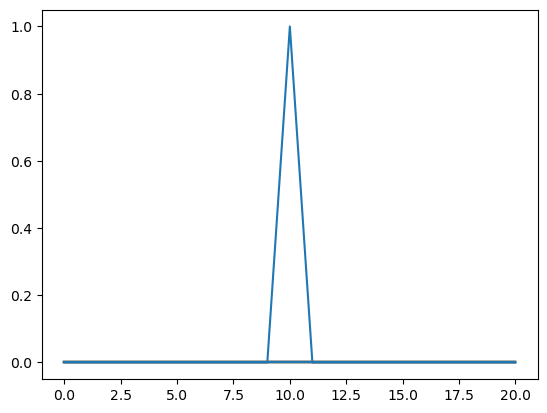

In [49]:
GRID_SIZE = 20
RADIUS = 5
PARTICLES =10000

SEED = (GRID_SIZE/2, GRID_SIZE/2)
# loop per particle
# 

grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
grid[int(SEED[0])][int(SEED[1])] = 1



def random_point_on_circle(x, y, radius):
    # Generate a random angle in radians
    angle = random.uniform(0, 2 * math.pi)
    # Calculate the point's coordinates
    point_x = x + radius * math.cos(angle)
    point_y = y + radius * math.sin(angle)
    return (int(point_x), int(point_y))

for _ in range(PARTICLES):
    
    
    
#     particle = (np.random.randint(0, GRID_SIZE/2 - RADIUS, GRID_SIZE/2 + RADIUS + 1), 
#                 np.random.randint(GRID_SIZE/2 - RADIUS, GRID_SIZE/2 + RADIUS + 1))


    particle = random_point_on_circle(SEED[0], SEED[1], RADIUS)
    print(particle)
    # random movement
    move = np.random.randint(0, 4)
    if move == 0:
        particle = (particle[0], particle[1] + 1)
    elif move == 1:
        particle = (particle[0] + 1, particle[1])
    elif move == 2:
        particle = (particle[0], particle[1] - 1)
    elif move == 3:
        particle = (particle[0] - 1, particle[1])
    else:
        print("Je moeder")

    if particle[0] + 1 > GRID_SIZE or particle[1] + 1 > GRID_SIZE or particle[0] - 1 < 0 or particle[1] - 1 < 0:
        continue
        

    if grid[particle[0], particle[1] + 1] == 1:
        grid[particle[0], particle[1]] = 1
        continue
    elif grid[particle[0] + 1, particle[1]] == 1:
        grid[particle[0], particle[1]] = 1
        continue
    elif grid[particle[0] - 1, particle[1]] == 1:
        grid[particle[0], particle[1]] = 1
        continue
    elif grid[particle[0], particle[1]-1] == 1:
        grid[particle[0], particle[1]] = 1
        continue
        
print(grid)


plt.plot(grid)
plt.show()


# when it comes to contact with cluster it attaches and stops moving 


# Attachment points are determined by nearest contact or interaction with other particles in the cluster.
# attaches at one unit distance with cluster




[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


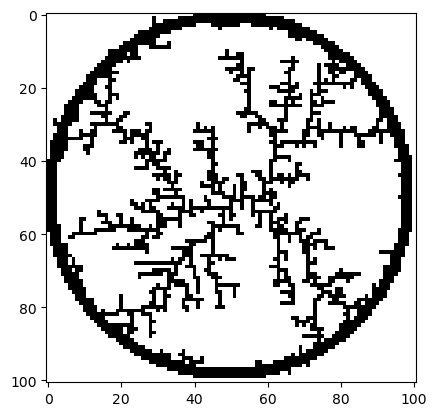

In [61]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 100
RADIUS = 49
PARTICLES = 100000
SEED = (GRID_SIZE // 2, GRID_SIZE // 2)  # Seed in the middle of the grid

# Initialize grid (plus 1 to account for 0-index)
grid = np.zeros((GRID_SIZE + 1, GRID_SIZE + 1))
grid[SEED[0], SEED[1]] = 1  # Set seed point as part of cluster

# Function to generate a random point on the circle
def random_point_on_circle(x, y, radius):
    angle = random.uniform(0, 2 * math.pi)  # Random angle in radians
    point_x = x + radius * math.cos(angle)  # Calculate x position
    point_y = y + radius * math.sin(angle)  # Calculate y position
    return (int(point_x), int(point_y))

# Loop over the number of particles
for _ in range(PARTICLES):
    # Create the particle starting from a random point on the circle
    particle = random_point_on_circle(SEED[0], SEED[1], RADIUS)
    while True:
        # Move the particle randomly
        move = np.random.randint(0, 4)  # Randomly select one of four directions
        if move == 0:
            particle = (particle[0], particle[1] + 1)  # Move up
        elif move == 1:
            particle = (particle[0] + 1, particle[1])  # Move right
        elif move == 2:
            particle = (particle[0], particle[1] - 1)  # Move down
        elif move == 3:
            particle = (particle[0] - 1, particle[1])  # Move left

        # Check if particle is out of bounds (ensure it's within grid size)
        if particle[0] < 0 or particle[1] < 0 or particle[0] >= GRID_SIZE or particle[1] >= GRID_SIZE:
            break

        # Check if the particle can attach to any adjacent grid cell (touches the cluster)
        if (grid[particle[0] + 1, particle[1]] == 1 or
            grid[particle[0] - 1, particle[1]] == 1 or
            grid[particle[0], particle[1] + 1] == 1 or
            grid[particle[0], particle[1] - 1] == 1):
            grid[particle[0], particle[1]] = 1  # Attach particle to the grid
            break  # Once attached, stop particle movement and move to the next particle

# Print the final grid and plot the result
print(grid)
plt.imshow(grid, cmap='Greys', interpolation='nearest')
plt.show()
